# Indice

1. [Introducción](#titulo_principal)
2. [Importación de librerías](#titulo_principal_1)
3. [Procesado de datos](#titulo_principal_2)
4. [Entreno de modelos sin considerar un desquilibrio de clases](#titulo_principal_3)
5. [Mejora de modelo](#titulo_principal_4)
6. [Prueba final](#titulo_principal_5)
7. [Conclusión](#titulo_principal_6)


## Introducción<a id="titulo_principal"></a>

En este proyecto, se trabajará con los datos de los clientes de Beta Bank. El banco ha estado experimentando una pérdida de clientes mes a mes, y el objetivo es obtener información valiosa que ayude a retener a estos clientes.

Para ello, se creará un modelo de aprendizaje automático (ML) que pueda predecir, en función de las variables de los datos de los clientes, si un cliente ha dejado de utilizar los servicios del banco o si sigue siendo un cliente activo.

En particular, se buscará calcular la métrica F1 con un valor mínimo de 0.59 para el mejor modelo, así como la métrica AUC-ROC, con el fin de evaluar si el modelo tiene un buen rendimiento en términos de sensibilidad y precisión, así como su capacidad para distinguir entre clases. En este caso, las clases son:

- **Exited:** El cliente se ha ido (1 - sí; 0 - no)

El proyecto se dividirá en varias etapas, desde la preparación de los datos hasta la evaluación del modelo, con un enfoque en mejorar la precisión y sensibilidad del mismo. Se utilizarán técnicas de balanceo de clases y se probarán diferentes enfoques para asegurar que el modelo final sea robusto y fiable.


## Importación de librerias<a id="titulo_principal_1"></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score


In [2]:
# Carga del dataset 

df = pd.read_csv('Churn.csv')

## Preprocesado de datos <a id="titulo_principal_2"></a>

### Observación de datos

In [3]:
print(df.head())

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0               1   
2     8.0  159660.80              3          1               0   
3     1.0       0.00              2          0               0   
4     2.0  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


- Veo que hay 10,000 entradas con 3 columnas tipo 'float', 8 tipo 'int', y 3 de tipo 'string'
- Todas las columnas exceptuando la septima llamada 'Tenure'
- En las especificaciones del dataset menciona:
     - **Tenure:** período durante el cual ha madurado el depósito a plazo fijo de un cliente (años)

    Posiblemente Ternure tiene muchas columnas nulas por temas de que hay clientes nuevos que llevan un periodo con plazo fijo insignificante

In [5]:
# Calculando cantidad de filas duplicadas

print(df.duplicated().sum())

0


In [6]:
print(df['Tenure'].value_counts())

Tenure
1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: count, dtype: int64


Como se puede observar, los datos nulos no se deben a un tema de que hay una falta de tiempo del cliente en la compañia, además se puede observar una disminución significativa de clientes en 10 años en la compañia

para poder rellenar estos datos nulos hay varias opciones: 

1. Eliminar filas que creo que no es una solucion viable puesto que casi el 10% de las entradas son nulas
2. Utilizar la media o la mediana para poder rellenar los datos según convenga
3. Colocar un 'Unknown' para rellenar los datos nulos que afectaria los modelos de ML

In [7]:
summary = df['Tenure'].describe().round(2)

print(summary)

count    9091.00
mean        5.00
std         2.89
min         0.00
25%         2.00
50%         5.00
75%         7.00
max        10.00
Name: Tenure, dtype: float64


Usare la mediana para rellenar los datos puesto que es similar a la media y no sesga, además modificare el tipo de dato pues float no es necesario para esta columna y puede ayudar a optimizar el tiempo de calculo

In [8]:
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median()).astype('int64')

print(summary)
print()
print(df.info())

count    9091.00
mean        5.00
std         2.89
min         0.00
25%         2.00
50%         5.00
75%         7.00
max        10.00
Name: Tenure, dtype: float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null

In [9]:
cantidad_valores_unicos_por_columna = df.nunique()
print(cantidad_valores_unicos_por_columna)

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64


### Codificación y escalado de varibales

In [10]:
data_ohe = (pd.get_dummies(df,drop_first=True).head(3))

print(data_ohe)
print(data_ohe.shape)

   RowNumber  CustomerId  CreditScore  Age  Tenure    Balance  NumOfProducts  \
0          1    15634602          619   42       2       0.00              1   
1          2    15647311          608   41       1   83807.86              1   
2          3    15619304          502   42       8  159660.80              3   

   HasCrCard  IsActiveMember  EstimatedSalary  ...  Surname_Zotova  \
0          1               1        101348.88  ...           False   
1          0               1        112542.58  ...           False   
2          1               0        113931.57  ...           False   

   Surname_Zox  Surname_Zubarev  Surname_Zubareva  Surname_Zuev  \
0        False            False             False         False   
1        False            False             False         False   
2        False            False             False         False   

   Surname_Zuyev  Surname_Zuyeva  Geography_Germany  Geography_Spain  \
0          False           False              False      

En este punto se crea un exceso de columnas, y esto es debido a que la columna 'Surname' con tiene valores unicos en una enorme cantidad, por lo que para nuestros calculos en realidad saber este dato es irrelevante, eliminare del dataset esta columna que tiene 2932 valores unicos

In [11]:
data_ohe = (pd.get_dummies(df.drop('Surname', axis=1),drop_first=True))

data_ohe


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,1,15634602,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,2,15647311,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False
2,3,15619304,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,4,15701354,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,5,15737888,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,771,39,5,0.00,2,1,0,96270.64,0,False,False,True
9996,9997,15569892,516,35,10,57369.61,1,1,1,101699.77,0,False,False,True
9997,9998,15584532,709,36,7,0.00,1,0,1,42085.58,1,False,False,False
9998,9999,15682355,772,42,3,75075.31,2,1,0,92888.52,1,True,False,True


Para realizar el escalado hay determinar cuales columnas son candidatas para este, en este caso:
    
    'CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary' son columnas que se beneficiarian de un escalado pues se comportan en un cierto rango y son numericas.

In [12]:
# Escalado de variables 

numeric = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Tenure']
scaler = StandardScaler()
scaler.fit(data_ohe[numeric])
data_ohe[numeric] = scaler.transform(data_ohe[numeric])
data_ohe[numeric] = scaler.transform(data_ohe[numeric])

# Resetear los índices de los DataFrames
data_ohe.reset_index(drop=True, inplace=True)
data_ohe.reset_index(drop=True, inplace=True)

# Eliminar coummnas innecesarias para el entreno del modelo

data_ohe = data_ohe.drop(['RowNumber', 'CustomerId'], axis=1)

# Convertir booleanos a enteros
data_ohe['Geography_Germany'] = data_ohe['Geography_Germany'].astype(int)
data_ohe['Geography_Spain'] = data_ohe['Geography_Spain'].astype(int)
data_ohe['Gender_Male'] = data_ohe['Gender_Male'].astype(int)

data_ohe

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,-6.734251,-3.683345,-2.204503,-1.225867,-4.198207,1,1,-1.740469,1,0,0,0
1,-6.735429,-3.692438,-2.335790,-1.225846,-4.198207,0,1,-1.740465,0,0,1,0
2,-6.746776,-3.683345,-1.416780,-1.225826,1.713916,1,0,-1.740465,1,0,0,0
3,-6.725686,-3.710622,-2.335790,-1.225867,-1.242146,0,0,-1.740471,0,0,0,0
4,-6.709521,-3.674253,-2.204503,-1.225835,-4.198207,1,1,-1.740476,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-6.717978,-3.710622,-1.810641,-1.225867,-1.242146,1,0,-1.740470,0,0,0,1
9996,-6.745278,-3.746992,-1.154206,-1.225853,-4.198207,1,1,-1.740469,0,0,0,1
9997,-6.724616,-3.737899,-1.548067,-1.225867,-4.198207,0,1,-1.740487,1,0,0,0
9998,-6.717871,-3.683345,-2.073216,-1.225848,-1.242146,1,0,-1.740471,1,1,0,1


### División del dataset en training, test y validación

In [13]:
# Primero, dividimos el dataset en entrenamiento y prueba
df_train_valid, df_test = train_test_split(data_ohe, test_size=0.2, random_state=12345)

# Luego, dividimos el conjunto de entrenamiento en entrenamiento y validación
df_train, df_valid = train_test_split(df_train_valid, test_size=0.25, random_state=12345)

# Verificamos los tamaños de cada conjunto
print("Tamaño del conjunto de entrenamiento:", df_train.shape)
print("Tamaño del conjunto de validación:", df_valid.shape)
print("Tamaño del conjunto de prueba:", df_test.shape)

Tamaño del conjunto de entrenamiento: (6000, 12)
Tamaño del conjunto de validación: (2000, 12)
Tamaño del conjunto de prueba: (2000, 12)


In [14]:
# Dividiendo dataset de entrenamiento en variables independientes y variable dependiente
features_train = df_train.drop(['Exited'], axis=1)
targets_train = df_train['Exited']
# Dividiendo dataset de validación en variables independientes y variable dependiente
features_valid = df_valid.drop(['Exited'], axis=1)
targets_valid = df_valid['Exited']

print(features_train.head())

features_train.shape

      CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
492     -6.732110 -3.719715 -1.941928 -1.225846      -1.242146          0   
6655    -6.741210 -3.665161 -1.810641 -1.225845      -4.198207          1   
4287    -6.724081 -3.583330 -2.335790 -1.225842      -4.198207          1   
42      -6.740995 -3.510592 -2.204503 -1.225837      -4.198207          1   
8178    -6.724830 -3.646976 -1.548067 -1.225835      -1.242146          1   

      IsActiveMember  EstimatedSalary  Geography_Germany  Geography_Spain  \
492                1        -1.740464                  0                0   
6655               1        -1.740482                  0                0   
4287               1        -1.740478                  1                0   
42                 1        -1.740471                  0                0   
8178               1        -1.740455                  0                0   

      Gender_Male  
492             0  
6655            1  
4287          

(6000, 11)

Con esto ya tenemos los datos procesados y listos para entrenar el modelo, previamente codificamos y escalamos las variables para poder ser entrenadas, eliminamos algunas columna innecesarias como el numero de fila y tambien el id del cliente, así como el apellido del mismo, 3 columnas que no tienen una gran relevancia para la clasificación final.

## Entreno del modelo sin considerar un desequilibrio <a id="titulo_principal_3"></a>

### Uso del modelo de arbol de desición

In [15]:
best_accuracy = 0
best_depth = 0
best_min_samples_split = 0

for depth in range(1, 21):
    for min_samples_split in range(2, 11):
        model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_split=min_samples_split)
        model_tree.fit(features_train, targets_train)
        predictions_valid = model_tree.predict(features_valid)
        accuracy = accuracy_score(targets_valid, predictions_valid)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_depth = depth
            best_min_samples_split = min_samples_split

print(f"Mejor exactitud en validación: {best_accuracy} con max_depth={best_depth} y min_samples_split={best_min_samples_split}")

Mejor exactitud en validación: 0.861 con max_depth=7 y min_samples_split=2


El modelo que da la mejor exactitud es con max_depth=7 y min_samples_split=2 de hiper-parametros

In [16]:
model = DecisionTreeClassifier(random_state=12345, max_depth=7, min_samples_split=2)
model.fit(features_train, targets_train)
predicted_valid = model.predict(features_valid)

# Calcular F1 Score
f1 = f1_score(predicted_valid, targets_valid)
print(f'F1 Score: {f1:.2f}')

# Hacer predicciones de probabilidad
y_pred_proba = model.predict_proba(features_valid)[:, 1]

# Calcular el AUC-ROC
auc_roc = roc_auc_score(targets_valid, y_pred_proba)
print(f'AUC-ROC: {auc_roc}')


F1 Score: 0.56
AUC-ROC: 0.8284887278877288


In [17]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.5, 0.02):
    predicted_valid = probabilities_one_valid > threshold# < escribe el código aquí >
    precision = precision_score(targets_valid, predicted_valid)# < escribe el código aquí >
    recall = recall_score(targets_valid, predicted_valid)# < escribe el código aquí >
    f1 = f1_score(targets_valid, predicted_valid)
    auc_roc = roc_auc_score(targets_valid, y_pred_proba)

    print(
        'Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, F1 = {:.3f}, AUC-ROC = {:.3f}'.format(
            threshold, precision, recall, f1, auc_roc
        )
    )

Threshold = 0.00 | Precision = 0.194, Recall = 0.972, F1 = 0.323, AUC-ROC = 0.828
Threshold = 0.02 | Precision = 0.230, Recall = 0.964, F1 = 0.371, AUC-ROC = 0.828
Threshold = 0.04 | Precision = 0.239, Recall = 0.951, F1 = 0.383, AUC-ROC = 0.828
Threshold = 0.06 | Precision = 0.274, Recall = 0.928, F1 = 0.424, AUC-ROC = 0.828
Threshold = 0.08 | Precision = 0.291, Recall = 0.895, F1 = 0.439, AUC-ROC = 0.828
Threshold = 0.10 | Precision = 0.388, Recall = 0.816, F1 = 0.526, AUC-ROC = 0.828
Threshold = 0.12 | Precision = 0.426, Recall = 0.780, F1 = 0.551, AUC-ROC = 0.828
Threshold = 0.14 | Precision = 0.426, Recall = 0.780, F1 = 0.551, AUC-ROC = 0.828
Threshold = 0.16 | Precision = 0.445, Recall = 0.749, F1 = 0.559, AUC-ROC = 0.828
Threshold = 0.18 | Precision = 0.468, Recall = 0.714, F1 = 0.565, AUC-ROC = 0.828
Threshold = 0.20 | Precision = 0.472, Recall = 0.706, F1 = 0.566, AUC-ROC = 0.828
Threshold = 0.22 | Precision = 0.472, Recall = 0.706, F1 = 0.566, AUC-ROC = 0.828
Threshold = 0.24

Como se puede observar el modelo de clasificación por arboles de desición con hiper-parametros por defecto da:
 - F1 Score: 0.49
 - AUC-ROC: 0.6880105353677126

Estos numero indican que al modelo tiene un rendimiento bajo en términos de equilibrio entre precisión y sensibilidad y que tiene una capacidad moderada para distinguir entre las clases, pero puede mejorar

Con el modelo que tiene los hiper-parametros que dan mejor exactitud da:
 - F1 Score: 0.56
 - AUC-ROC: 0.8284887278877288

En este caso el modelo a mejorado en terminos de sensibilidad y presición pero muy poco, aunque el AUC-ROC ha mejorado bastante y esto supone que el modelo distigue mucho mejor entre clases 

Además el mejor F1 viene cuando el limite es 0.28:

    Threshold = 0.28 | Precision = 0.527, Recall = 0.655, F1 = 0.584, AUC-ROC = 0.828

A continuación probare con el de bosques aleatorios a ver si mejoran las metricas 

### Uso del modelo de bosque aleatorio

In [18]:
best_accuracy = 0
best_depth = 0
best_n_estimators = 0
best_min_samples_split = 0
for depth in range(1, 11):
    for n_estimators in range(50, 100, 10): 
        for min_samples_split in range(2, 11):
            model_tree = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n_estimators, min_samples_split = min_samples_split)
            model_tree.fit(features_train, targets_train)
            predictions_valid = model_tree.predict(features_valid)
            accuracy = accuracy_score(targets_valid, predictions_valid)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_depth = depth
                best_n_estimators = n_estimators
                best_min_samples_split = min_samples_split

print(f"Mejor exactitud en validación: {best_accuracy} con max_depth={best_depth}, con min_sample_split={best_min_samples_split} y n_estimators={best_n_estimators}")

Mejor exactitud en validación: 0.867 con max_depth=9, con min_sample_split=6 y n_estimators=50


In [19]:
# Ajuste de modelo con hiper-parametros mas eficientes
model_RandomForest = RandomForestClassifier(random_state=12345, max_depth=15, min_samples_split=4, n_estimators=60)

# Entrenar modelo con los datos
model_RandomForest.fit(features_train, targets_train)
predicted_valid = model_RandomForest.predict(features_valid)

# Calcular F1 Score
f1 = f1_score(predicted_valid, targets_valid)
print(f'F1 Score: {f1:.2f}')

# Hacer predicciones de probabilidad
y_pred_proba = model_RandomForest.predict_proba(features_valid)[:, 1]

# Calcular el AUC-ROC
auc_roc = roc_auc_score(targets_valid, y_pred_proba)
print(f'AUC-ROC: {auc_roc}')


F1 Score: 0.58
AUC-ROC: 0.84752884589402


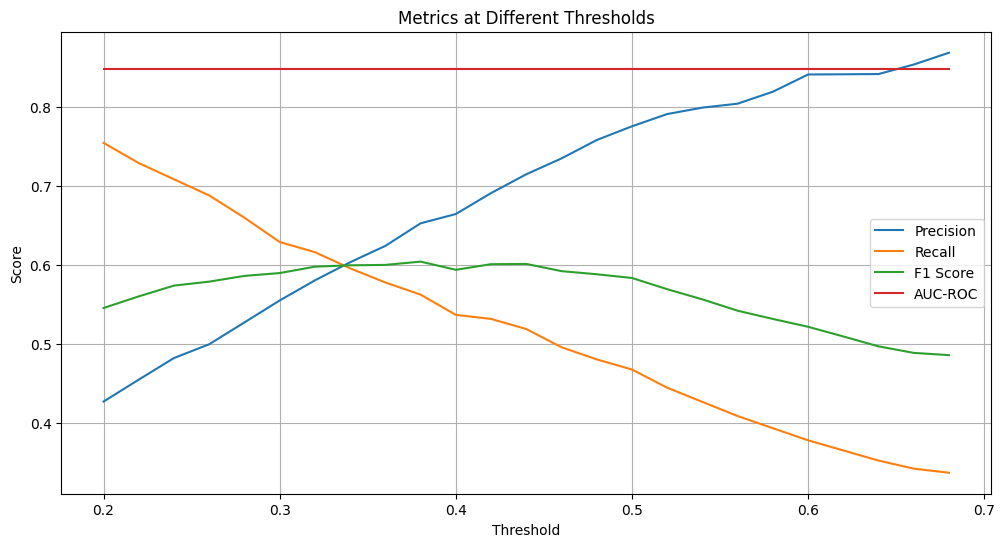

In [20]:

probabilities_valid = model_RandomForest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

# Listas para almacenar las métricas en función del umbral
thresholds = np.arange(0.2, 0.7, 0.02)
precision_scores = []
recall_scores = []
f1_scores = []
auc_roc_scores = []

for threshold in thresholds:
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(targets_valid, predicted_valid)
    recall = recall_score(targets_valid, predicted_valid)
    f1 = f1_score(targets_valid, predicted_valid)
    auc_roc = roc_auc_score(targets_valid, probabilities_one_valid)
    
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    auc_roc_scores.append(auc_roc)

# Crear el gráfico
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, auc_roc_scores, label='AUC-ROC')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics at Different Thresholds')
plt.legend()
plt.grid(True)
plt.show()


En este caso la situación mejora, con la mejor exactitud en validación: 0.8695 con max_depth=15, con min_sample_split=4 y n_estimators=60 devuelve un:
 - F1 Score: 0.58
 - AUC-ROC: 0.84752884589402

Además, si iteramos en diversos limites mejora aún más:

    Threshold = 0.38 | Precision = 0.653, Recall = 0.563, F1 = 0.604, AUC-ROC = 0.848

Esto ya supera umbral requerido pero se puede mejorar con un ajuste con la corrección de desequilibrio de clases

## Mejora del modelo <a id="titulo_principal_4"></a>

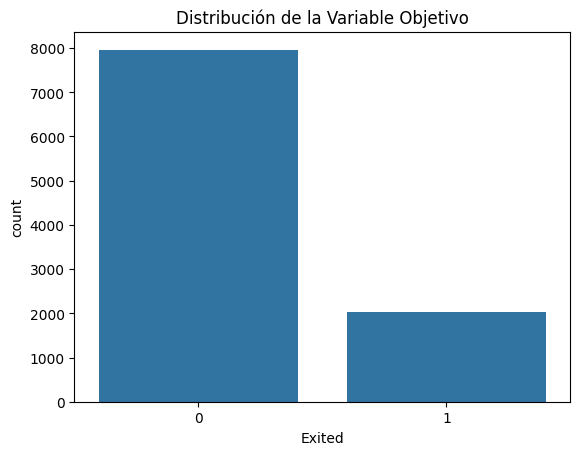

In [21]:
# Visualizar la distribución de clases
sns.countplot(x='Exited', data=df)
plt.title('Distribución de la Variable Objetivo')
plt.show()

In [22]:
# Distribución de la variable objetivo
class_distribution = df['Exited'].value_counts()

print(class_distribution)

Exited
0    7963
1    2037
Name: count, dtype: int64


Veo un desequilibrio my claro de clases, las personas que no se han ido son muchisimo más comunes, en la proporción siguiente:

    0  :  7963
    
    1  :  2037


### Sobremuestreo

Utilizare 'data_ohe' que es el dataset donde ya escale y clasifique los datos

In [23]:
# Calculando las veces que se debe de multiplicar las carcteristicas con valor de 1 para ser balanceada

ones = data_ohe['Exited'][data_ohe['Exited'] == 1].count()
zeros = data_ohe['Exited'][data_ohe['Exited'] == 0].count()

repeat = zeros/ones


In [24]:
#  Esta función multiplica la caracteristica rara para balanceo de clases

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    repeat_int = int(zeros/ones)

    # Parte fraccionaria de repeat
    repeat_frac = repeat - repeat_int
    
    arg1 = pd.concat([features_zeros] + [features_ones] * repeat_int)
    arg2 = pd.concat([target_zeros] + [target_ones] * repeat_int)
    
    
    # Sobremuestreo con la parte fraccionaria
    if repeat_frac > 0:
        frac_sample = features_ones.sample(frac=repeat_frac, random_state=12345)
        frac_target = target_ones.sample(frac=repeat_frac, random_state=12345)
        upsampled_features = pd.concat([arg1, frac_sample])
        upsampled_target = pd.concat([arg2, frac_target])
        
    features_upsampled, target_upsampled = shuffle(upsampled_features, upsampled_target, random_state=12345)
  
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, targets_train, repeat)

print(features_upsampled.shape)
print(target_upsampled.shape)

(9546, 11)
(9546,)


In [25]:
# Chequeo de balance

# Distribución de la variable objetivo
class_distribution = target_upsampled.value_counts()
print(class_distribution)

Exited
0    4781
1    4765
Name: count, dtype: int64


In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
import pandas as pd

# Suponiendo que features_train, target_train, features_valid y targets_valid están definidos

# Escalar los datos
scaler = MaxAbsScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_valid_scaled = scaler.transform(features_valid)

# Sobremuestreo utilizando SMOTE en los datos escalados
smote = SMOTE(random_state=42)
features_upsampled_scaled, target_upsampled = smote.fit_resample(features_train_scaled, targets_train)

# Entrenamiento del modelo KNN sin escalar (usando datos originales para comparación)
results = []
for k in range(1, 11):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(features_train, targets_train)
    predictions = model.predict(features_valid)
    f1 = f1_score(targets_valid, predictions)
    results.append({'k': k, 'F1 (original)': f1})

# Entrenamiento del modelo KNN con características escaladas y sobremuestreo
for k in range(1, 11):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(features_upsampled_scaled, target_upsampled)
    predictions = model.predict(features_valid_scaled)
    f1 = f1_score(targets_valid, predictions)
    results[k-1]['F1 (scaled)'] = f1

# Convertir los resultados a DataFrame para visualización
results_df = pd.DataFrame(results)
print(results_df)


ModuleNotFoundError: No module named 'imblearn'

Con esto confirmamos que estan balanceadas las clases y pasamos a los modelos

#### Modelo de bosque aleatorio (Con clases balanceadas)

In [26]:
best_accuracy = 0
best_depth = 0
best_n_estimators = 0
best_min_samples_split = 0
for depth in range(1, 11):
    for n_estimators in range(50, 100, 10): 
        for min_samples_split in range(2, 11):
            model_tree = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n_estimators, min_samples_split = min_samples_split)
            model_tree.fit(features_upsampled, target_upsampled)
            predictions_valid = model_tree.predict(features_valid)
            accuracy = accuracy_score(targets_valid, predictions_valid)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_depth = depth
                best_n_estimators = n_estimators
                best_min_samples_split = min_samples_split

print(f"Mejor exactitud en validación: {best_accuracy} con max_depth={best_depth}, con min_sample_split={best_min_samples_split} y n_estimators={best_n_estimators}")

Mejor exactitud en validación: 0.824 con max_depth=10, con min_sample_split=4 y n_estimators=50


El modelo con mejor exactitud y parametros no mejoro el que fue entrenado con los datos sin balancear clases, veamos si mejora f1 y AUC-ROC

In [27]:
# Ajuste de modelo con hiper-parametros mas eficientes
model_RandomForest = RandomForestClassifier(random_state=12345, max_depth=10, min_samples_split=4, n_estimators=50)

# Entrenar modelo con los datos
model_RandomForest.fit(features_upsampled, target_upsampled)
predicted_valid = model_RandomForest.predict(features_valid)

# Calcular F1 Score
f1 = f1_score(predicted_valid, targets_valid)
print(f'F1 Score: {f1:.2f}')

# Hacer predicciones de probabilidad
y_pred_proba = model_RandomForest.predict_proba(features_valid)[:, 1]

# Calcular el AUC-ROC
auc_roc = roc_auc_score(targets_valid, y_pred_proba)
print(f'AUC-ROC: {auc_roc}')


F1 Score: 0.60
AUC-ROC: 0.8526351930238953


#### Ajuste del umbral

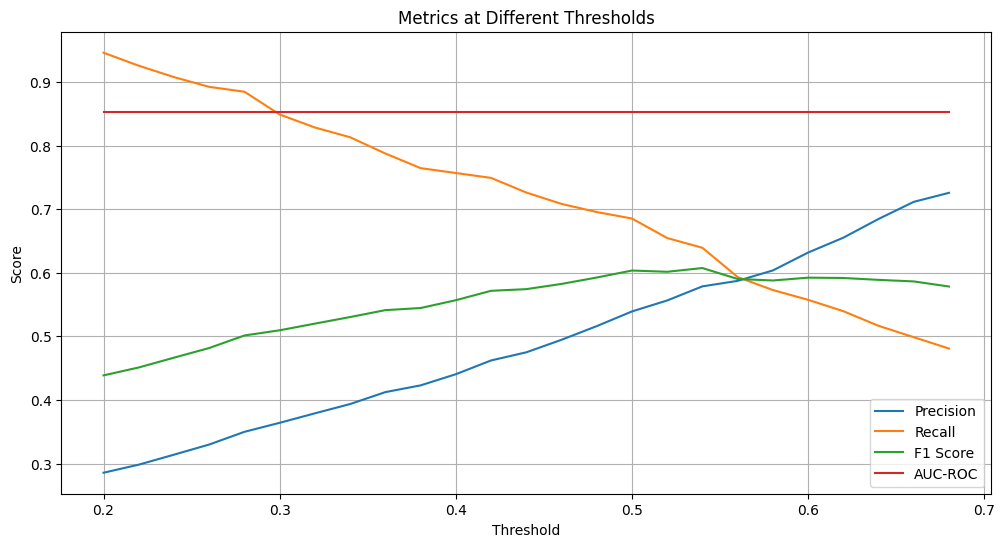

In [28]:
probabilities_valid = model_RandomForest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

# Listas para almacenar las métricas en función del umbral
thresholds = np.arange(0.2, 0.7, 0.02)
precision_scores = []
recall_scores = []
f1_scores = []
auc_roc_scores = []

for threshold in thresholds:
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(targets_valid, predicted_valid)
    recall = recall_score(targets_valid, predicted_valid)
    f1 = f1_score(targets_valid, predicted_valid)
    auc_roc = roc_auc_score(targets_valid, probabilities_one_valid)
    
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    auc_roc_scores.append(auc_roc)

# Crear el gráfico
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, auc_roc_scores, label='AUC-ROC')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics at Different Thresholds')
plt.legend()
plt.grid(True)
plt.show()


Este modelo sin ajuste de umbral mejora al modelo que no tenia las clases balanceadas: 

**Modelo sin clases balanceada** 
- F1 Score: 0.58
- AUC-ROC: 0.84752884589402

**Modelo con clases balanceada** 
- F1 Score: 0.60
- AUC-ROC: 0.8526351930238953

Además mostrare ambas con el mejor umbral:

**Modelo sin clases balanceada** 

    Threshold = 0.38 | Precision = 0.653, Recall = 0.563, F1 = 0.604, AUC-ROC = 0.848

**Modelo con clases balanceada** 

    Threshold = 0.54 | Precision = 0.579, Recall = 0.639, F1 = 0.608, AUC-ROC = 0.853

A continuación usare el metodo de 'Ajuste de pesos de clase' para observar si mejora las metricas

Usare los datos sin utilizar el 'sobremuestreo'o sea, features_train y targets_train para entrenar el modelo

#### Ajuste de pesos de clase



In [29]:
best_accuracy = 0
best_depth = 0
best_n_estimators = 0
best_min_samples_split = 0
for depth in range(1, 11):
    for n_estimators in range(50, 100, 10): 
        for min_samples_split in range(2, 11):
            # Coloco el ajuste de peso de clase
            model_tree = RandomForestClassifier(class_weight='balanced', random_state=12345, max_depth=depth, n_estimators=n_estimators, min_samples_split = min_samples_split)
            model_tree.fit(features_train, targets_train)
            predictions_valid = model_tree.predict(features_valid)
            accuracy = accuracy_score(targets_valid, predictions_valid)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_depth = depth
                best_n_estimators = n_estimators
                best_min_samples_split = min_samples_split

print(f"Mejor exactitud en validación: {best_accuracy} con max_depth={best_depth}, con min_sample_split={best_min_samples_split} y n_estimators={best_n_estimators}")

Mejor exactitud en validación: 0.841 con max_depth=10, con min_sample_split=2 y n_estimators=60


In [30]:
# Ajuste de modelo con hiper-parametros mas eficientes
model_RandomForest = RandomForestClassifier(class_weight='balanced', random_state=12345, max_depth=10, min_samples_split=4, n_estimators=60)

# Entrenar modelo con los datos
model_RandomForest.fit(features_train, targets_train)
predicted_valid = model_RandomForest.predict(features_valid)

# Calcular F1 Score
f1 = f1_score(predicted_valid, targets_valid)
print(f'F1 Score: {f1:.2f}')

# Hacer predicciones de probabilidad
y_pred_proba = model_RandomForest.predict_proba(features_valid)[:, 1]

# Calcular el AUC-ROC
auc_roc = roc_auc_score(targets_valid, y_pred_proba)
print(f'AUC-ROC: {auc_roc}')


F1 Score: 0.59
AUC-ROC: 0.8481209437324259


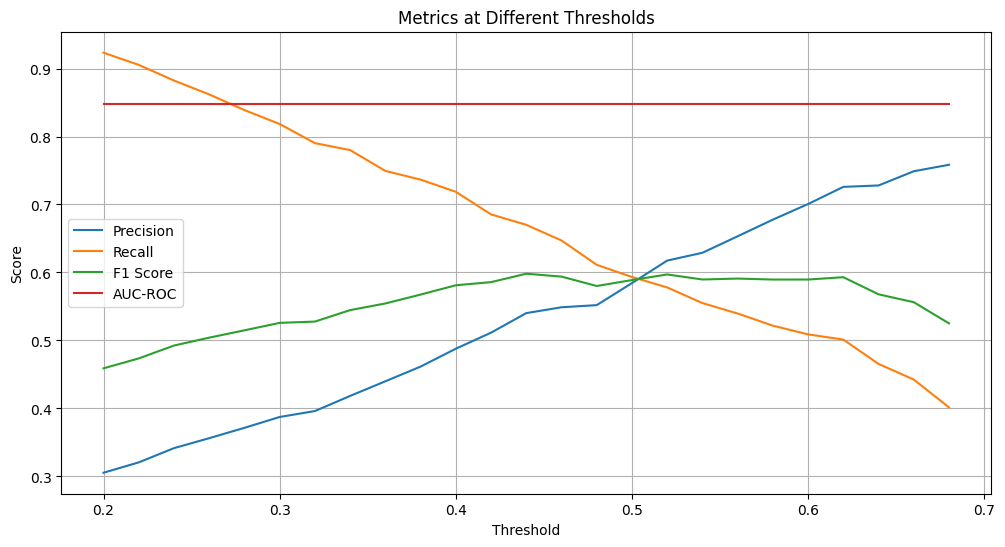

In [31]:
probabilities_valid = model_RandomForest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

# Listas para almacenar las métricas en función del umbral
thresholds = np.arange(0.2, 0.7, 0.02)
precision_scores = []
recall_scores = []
f1_scores = []
auc_roc_scores = []

for threshold in thresholds:
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(targets_valid, predicted_valid)
    recall = recall_score(targets_valid, predicted_valid)
    f1 = f1_score(targets_valid, predicted_valid)
    auc_roc = roc_auc_score(targets_valid, probabilities_one_valid)
    
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    auc_roc_scores.append(auc_roc)

# Crear el gráfico
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, auc_roc_scores, label='AUC-ROC')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics at Different Thresholds')
plt.legend()
plt.grid(True)
plt.show()


El uso de ajustes de peso de clase no mejora al de sobremuestreo en el caso del modelo de bosque aleatorio


    Threshold = 0.46 | Precision = 0.549, Recall = 0.647, F1 = 0.594, AUC-ROC = 0.848

#### Modelo de regresión logistica (Con clases balanceadas)

In [32]:
# Definir la búsqueda en cuadrícula de parámetros
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']
}

model_logisticReg = LogisticRegression(random_state=12345, max_iter=10000)

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=model_logisticReg, param_grid=param_grid, cv=5, scoring='accuracy')

# Ejecutar la búsqueda en cuadrícula
grid_search.fit(features_upsampled, target_upsampled)

# Obtener los mejores parámetros y la mejor exactitud
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print(f"Mejores parámetros: {best_params}")
print(f"Mejor exactitud en validación (con CV): {best_accuracy}")

Mejores parámetros: {'C': 100, 'solver': 'liblinear'}
Mejor exactitud en validación (con CV): 0.701864741003623


In [33]:
# Ajuste de modelo con hiper-parametros mas eficientes
model_logisticReg = LogisticRegression(random_state=12345, max_iter=10000,C= 100, solver='liblinear')


# Entrenar modelo con los datos
model_logisticReg.fit(features_upsampled, target_upsampled)
predicted_valid = model_logisticReg.predict(features_valid)

# Calcular F1 Score
f1 = f1_score(predicted_valid, targets_valid)
print(f'F1 Score: {f1:.2f}')

# Hacer predicciones de probabilidad
y_pred_proba = model_logisticReg.predict_proba(features_valid)[:, 1]

# Calcular el AUC-ROC
auc_roc = roc_auc_score(targets_valid, y_pred_proba)
print(f'AUC-ROC: {auc_roc}')

F1 Score: 0.49
AUC-ROC: 0.7743431687804693


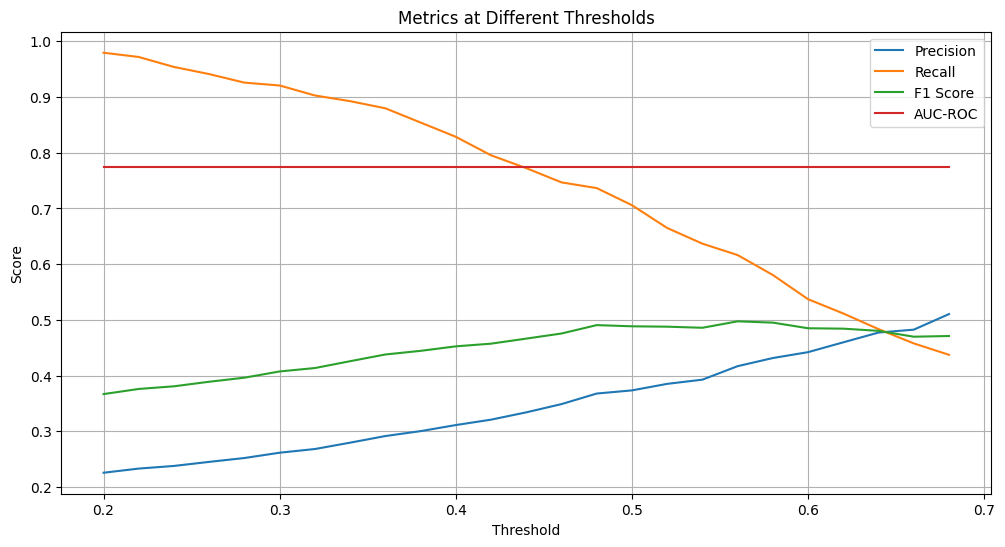

In [34]:

probabilities_valid = model_logisticReg.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

# Listas para almacenar las métricas en función del umbral
thresholds = np.arange(0.2, 0.7, 0.02)
precision_scores = []
recall_scores = []
f1_scores = []
auc_roc_scores = []

for threshold in thresholds:
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(targets_valid, predicted_valid)
    recall = recall_score(targets_valid, predicted_valid)
    f1 = f1_score(targets_valid, predicted_valid)
    auc_roc = roc_auc_score(targets_valid, probabilities_one_valid)
    
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    auc_roc_scores.append(auc_roc)

# Crear el gráfico
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, auc_roc_scores, label='AUC-ROC')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics at Different Thresholds')
plt.legend()
plt.grid(True)
plt.show()


El modelo de regresión logistica no llega a mejorar al modelo de bosques aleaotrios con clases balnceadas, estos son los valores que arroja el mejor modelo:

- F1 Score: 0.49
- AUC-ROC: 0.7743431687804693

Probare ahora con el parametro 'class_weight'

In [35]:
# Ajuste de modelo con hiper-parametros mas eficientes
model_logisticReg = LogisticRegression(class_weight='balanced', random_state=12345, max_iter=10000,C= 100, solver='liblinear')


# Entrenar modelo con los datos
model_logisticReg.fit(features_train, targets_train)
predicted_valid = model_logisticReg.predict(features_valid)

# Calcular F1 Score
f1 = f1_score(predicted_valid, targets_valid)
print(f'F1 Score: {f1:.2f}')

# Hacer predicciones de probabilidad
y_pred_proba = model_logisticReg.predict_proba(features_valid)[:, 1]

# Calcular el AUC-ROC
auc_roc = roc_auc_score(targets_valid, y_pred_proba)
print(f'AUC-ROC: {auc_roc}')

F1 Score: 0.49
AUC-ROC: 0.7743781383172341


Da un resultado muy similar, por lo tanto concluimos que no llega a ser tan buen modelo

#### Modelo de arbol de desición (Con clases balanceadas)

In [36]:
best_accuracy = 0
best_depth = 0
best_min_samples_split = 0

for depth in range(1, 25):
    for min_samples_split in range(2, 25):
        model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_split=min_samples_split)
        model_tree.fit(features_upsampled, target_upsampled)
        predictions_valid = model_tree.predict(features_valid)
        accuracy = accuracy_score(targets_valid, predictions_valid)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_depth = depth
            best_min_samples_split = min_samples_split

print(f"Mejor exactitud en validación: {best_accuracy} con max_depth={best_depth} y min_samples_split={best_min_samples_split}")

Mejor exactitud en validación: 0.801 con max_depth=22 y min_samples_split=5


In [37]:
model = DecisionTreeClassifier(random_state=12345, max_depth=22, min_samples_split=5)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

# Calcular F1 Score
f1 = f1_score(predicted_valid, targets_valid)
print(f'F1 Score: {f1:.2f}')

# Hacer predicciones de probabilidad
y_pred_proba = model.predict_proba(features_valid)[:, 1]

# Calcular el AUC-ROC
auc_roc = roc_auc_score(targets_valid, y_pred_proba)
print(f'AUC-ROC: {auc_roc}')

F1 Score: 0.49
AUC-ROC: 0.6821952603561489


Este modelo con clases balanceadas es el peor hasta hoara con:
 - F1 Score: 0.49
 - AUC-ROC: 0.6821952603561489

Ahora lo hare con el metodo de 'Ajustes de peso de clase'

In [38]:
best_accuracy = 0
best_depth = 0
best_min_samples_split = 0

for depth in range(1, 25):
    for min_samples_split in range(2, 25):
        model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_split=min_samples_split)
        model_tree.fit(features_train, targets_train)
        predictions_valid = model_tree.predict(features_valid)
        accuracy = accuracy_score(targets_valid, predictions_valid)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_depth = depth
            best_min_samples_split = min_samples_split

print(f"Mejor exactitud en validación: {best_accuracy} con max_depth={best_depth} y min_samples_split={best_min_samples_split}")

Mejor exactitud en validación: 0.861 con max_depth=7 y min_samples_split=2


In [39]:
model = DecisionTreeClassifier(class_weight='balanced', random_state=12345, max_depth=7, min_samples_split=2)
model.fit(features_train, targets_train)
predicted_valid = model.predict(features_valid)

# Calcular F1 Score
f1 = f1_score(predicted_valid, targets_valid)
print(f'F1 Score: {f1:.2f}')

# Hacer predicciones de probabilidad
y_pred_proba = model.predict_proba(features_valid)[:, 1]

# Calcular el AUC-ROC
auc_roc = roc_auc_score(targets_valid, y_pred_proba)
print(f'AUC-ROC: {auc_roc}')

F1 Score: 0.56
AUC-ROC: 0.8083391218513508


Cierro este apartado del proyecto con las siguientes observaciones:

- Al utilizar las caracteristicas y targets con el balance de clases siempre se reduce la exactitud a cambio de mejorar f1 y AUC-ROC
- El mejor modelo fue el de Bosques aleatorios usando el balance de clases que dio:

       Threshold = 0.54 | Precision = 0.579, Recall = 0.639, F1 = 0.608, AUC-ROC = 0.853


A continuación usaré este modelo para testearlo en una pruba final con los datos del 'df_test' que se genero al dividir los datos en prueba, entrenamiento y validación

## Prueba final <a id="titulo_principal_5"></a>

In [40]:
# Dividiendo dataset de testeo en variables independientes y variable dependiente
features_test = df_test.drop(['Exited'], axis=1)
targets_test = df_test['Exited']

In [41]:
# Ajuste de modelo con hiper-parametros mas eficientes
model_RandomForest = RandomForestClassifier(random_state=12345, max_depth=10, min_samples_split=4, n_estimators=50)

# Entrenar modelo con los datos balanceados
model_RandomForest.fit(features_upsampled, target_upsampled)
predicted_test = model_RandomForest.predict(features_test)

# Calcular F1 Score
f1 = f1_score(predicted_test, targets_test)
print(f'F1 Score: {f1:.2f}')

# Hacer predicciones de probabilidad
y_pred_proba = model_RandomForest.predict_proba(features_test)[:, 1]

# Calcular el AUC-ROC
auc_roc = roc_auc_score(targets_test, y_pred_proba)
print(f'AUC-ROC: {auc_roc}')

# Calculo de exactitud
accuracy = accuracy_score(targets_test, predicted_test)
print(f'Accuracy: {accuracy}')


F1 Score: 0.63
AUC-ROC: 0.8642400818257747
Accuracy: 0.829


Los resultados fueron muy buenos, incluso mejores que en el conjunto de validación:

- F1 Score: 0.63
- AUC-ROC: 0.8642400818257747
- Accuracy: 0.829

Veremos que pasa si ajustamos el umbral

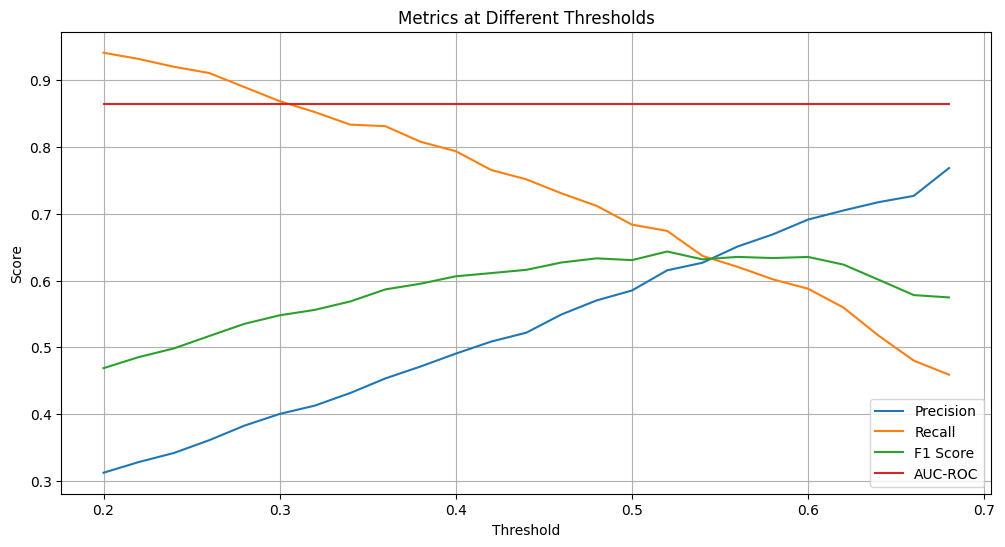

In [42]:
probabilities_test = model_RandomForest.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

# Listas para almacenar las métricas en función del umbral
thresholds = np.arange(0.2, 0.7, 0.02)
precision_scores = []
recall_scores = []
f1_scores = []
auc_roc_scores = []

for threshold in thresholds:
    predicted_test = probabilities_one_test > threshold
    precision = precision_score(targets_test, predicted_test)
    recall = recall_score(targets_test, predicted_test)
    f1 = f1_score(targets_test, predicted_test)
    auc_roc = roc_auc_score(targets_test, probabilities_one_test)
    
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    auc_roc_scores.append(auc_roc)

# Crear el gráfico
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, auc_roc_scores, label='AUC-ROC')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics at Different Thresholds')
plt.legend()
plt.grid(True)
plt.show()

Ajustando el umbral a 0.52 F1 mejora incluso más:

    Threshold = 0.52 | Precision = 0.615, Recall = 0.674, F1 = 0.644, AUC-ROC = 0.864

## Conclusión <a id="titulo_principal_6"></a>

En este proyecto, se realizaron los siguientes pasos:

1. **Procesamiento de datos:** Se rellenaron los valores faltantes y se ajustaron los tipos de datos en algunas columnas.
2. **Eliminación de columnas irrelevantes:** Se suprimieron columnas sin utilidad para el modelo como 'RowNumber', 'CustomerId' y 'Surname'.
3. **Codificación y escalado:** Se codificaron los valores de las columnas categóricas y se escalaron las columnas numéricas para preparar los datos para los modelos.
4. **División del conjunto de datos:** Se dividió el conjunto de datos en subconjuntos de entrenamiento, prueba y validación.
5. **Entrenamiento de modelos iniciales:** Se entrenaron modelos sin considerar el desbalanceo de clases.
6. **Balanceo de clases:** Se crearon conjuntos de datos balanceados mediante sobremuestreo y ajuste de pesos de clase, y se itero sobre diferentes umbrales.
7. **Mejor modelo:** El mejor modelo fue el de Bosques Aleatorios usando balanceo de clases, con los siguientes resultados:

       Threshold = 0.54 | Precision = 0.579, Recall = 0.639, F1 = 0.608, AUC-ROC = 0.853

8. **Evaluación en conjunto de prueba:** El modelo mencionado se evaluó en el conjunto de prueba con resultados aún mejores:
   - F1 Score: 0.63
   - AUC-ROC: 0.864
   - Accuracy: 0.829

9. **Ajuste de umbral:** Se ajustó el umbral del modelo, superando el F1 requerido de 0.59:

       Threshold = 0.52 | Precision = 0.615, Recall = 0.674, F1 = 0.644, AUC-ROC: 0.864

En resumen, el proyecto ha cumplido con éxito el objetivo de desarrollar un modelo predictivo robusto para identificar la posible salida de clientes, superando los criterios establecidos.
